In [1]:
# Mostrar todas las columnas (sin truncar)

import pandas as pd

pd.options.display.max_columns = None

# Mostrar todas las filas (sin truncar)
pd.options.display.max_rows = None

# Establecer el ancho de la columna para evitar truncamiento
pd.options.display.width = 1000

# Formatear números de punto flotante para mostrar hasta 2 decimales
pd.options.display.float_format = '{:.2f}'.format

# Si quieres que se muestre el índice en la salida
pd.options.display.show_dimensions = True

import warnings
warnings.filterwarnings('ignore')

# Ignorar warnings específicos de bibliotecas comunes
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Para XGBoost específicamente
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

# Para pandas
import pandas as pd
pd.options.mode.chained_assignment = None  # Desactivar SettingWithCopyWarning

In [11]:
from scipy.stats import poisson

lambda_ = 10.5
prob_over_9_5 = 1 - poisson.cdf(9, lambda_)


In [12]:
prob_over_9_5

np.float64(0.6028674006491892)

In [ ]:
import soccerdata as sd
import pandas as pd
fbref = sd.FBref(leagues="FRA-Ligue 1", seasons=2019)
team_season_shooting = fbref.read_team_match_stats(stat_type="shooting",opponent_stats = False)
team_season_passing_types = fbref.read_team_match_stats(stat_type="passing_types",opponent_stats = False)
team_season_goalkeeping = fbref.read_team_match_stats(stat_type="keeper",opponent_stats = False)
team_season_goal_shot_creation = fbref.read_team_match_stats(stat_type="goal_shot_creation",opponent_stats = False)
team_season_goal_misc = fbref.read_team_match_stats(stat_type="misc",opponent_stats = False)
team_season_goal_possession = fbref.read_team_match_stats(stat_type="possession",opponent_stats = False)

[10/29/25 10:20:55] INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=633284;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=875245;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

In [ ]:
import soccerdata as sd
import pandas as pd
# Create scraper class instance
lst_years = [2017,2018,2019,2020,2021,2022,2023,2024]
dic_historic = {}

for i in lst_years:
    #fbref = sd.FBref(leagues="ESP-La Liga", seasons=i)
    fbref = sd.FBref(leagues="GER-Bundesliga", seasons=i)
    
    team_season_shooting = fbref.read_team_match_stats(stat_type="shooting",opponent_stats = False)
    team_season_passing_types = fbref.read_team_match_stats(stat_type="passing_types",opponent_stats = False)
    team_season_goalkeeping = fbref.read_team_match_stats(stat_type="keeper",opponent_stats = False)
    team_season_goal_shot_creation = fbref.read_team_match_stats(stat_type="goal_shot_creation",opponent_stats = False)
    team_season_goal_misc = fbref.read_team_match_stats(stat_type="misc",opponent_stats = False)
    team_season_goal_possession = fbref.read_team_match_stats(stat_type="possession",opponent_stats = False)


    df_concat = pd.concat([team_season_shooting,team_season_passing_types,team_season_goalkeeping,team_season_goal_shot_creation,team_season_goal_misc,team_season_goal_possession], axis=1)
    
    df_reset = df_concat.copy().reset_index()

    # Aplanar MultiIndex uniendo ambos niveles con guion bajo
    df_reset.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col 
                        for col in df_reset.columns.values]

    # Ver columnas
    print(df_reset.columns.tolist())

    # Eliminar columnas duplicadas (mantiene la primera)
    df_reset = df_reset.loc[:, ~df_reset.columns.duplicated()]


    lst_base = ['season','date','game','round','day','venue','team','GF','GA','opponent',"result"]

    lst_columns_passing_type = ['Pass Types_CK']
    lst_columns_shooting = ['Expected_xG']
    lst_columns_keeper = []
    lst_columns_shot_creation = ['SCA Types_SCA']
    lst_columns_misc = ['Performance_Crs']
    #lst_columns_possesion = ['Poss', 'Touches_Att 3rd','Carries_PrgC']
    lst_columns_possesion = ['Poss', 'Touches_Att 3rd']
    # Ahora filtrar con nombres completos
    df_filtered = df_reset[lst_base + lst_columns_passing_type +lst_columns_shooting+lst_columns_keeper+lst_columns_shot_creation+lst_columns_misc+lst_columns_possesion]

    # Función segura para extraer equipos
    def extract_local(game_str):
        try:
            parts = game_str.split(" ",1)[1].split("-")
            return parts[0] if len(parts) > 0 else None
        except (IndexError, AttributeError):
            return None
    
    def extract_away(game_str):
        try:
            parts = game_str.split(" ",1)[1].split("-")
            return parts[1] if len(parts) > 1 else None
        except (IndexError, AttributeError):
            return None
    
    df_filtered["local"] = df_filtered["game"].apply(extract_local)
    df_filtered["away"] = df_filtered["game"].apply(extract_away)
    
    # Verificar valores problemáticos
    problematic = df_filtered[df_filtered["away"].isna()]
    if len(problematic) > 0:
        print(f"⚠️ Año {i}: {len(problematic)} registros con formato incorrecto en 'game'")
        print(problematic[["game", "local", "away"]].head())
    
    dic_historic[i] = df_filtered

# Los valores que no se puedan extraer quedarán como NaN automáticamente

# Opción 1: Concatenar verticalmente (apilar filas) - MÁS COMÚN
df_database = pd.concat(dic_historic.values(), ignore_index=True)

df_database = df_database[df_database['round'].str.contains("Matchweek", na=False)]
df_database['round'] = df_database['round'].str.replace("Matchweek ","")

df_database['round'] = df_database['round'].astype(int)
df_database['GF'] = df_database['GF'].astype(int)
df_database['GA'] = df_database['GA'].astype(int)

df_database_export = df_database.copy()

df_database_export = df_database_export.drop_duplicates(subset=["game"])
df_database_export = df_database_export[["local","away","round","season","date"]]
lst_1=df_database_export.values.tolist()

# Crear nueva lista sin elementos que cumplan condición
lst_1 = [row for row in lst_1 if row[3] != "1718"]

[10/28/25 21:45:39] INFO     No custom team name replacements found. You can configure these in       ]8;id=875076;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=976232;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_config.py#91\91]8;;\
                             C:\Users\Danie\soccerdata\config\teamname_replacements.json.                          

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=727321;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=654295;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_config.py#224\224]8;;\
                             C:\Users\Danie\soccerdata\config\league_dict.json.                                    

                    INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=813136;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=742113;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

['league', 'season', 'team', 'game', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%', 'Standard_G/Sh', 'Standard_G/SoT', 'Standard_Dist', 'Standard_FK', 'Standard_PK', 'Standard_PKatt', 'Expected_xG', 'Expected_npxG', 'Expected_npxG/Sh', 'Expected_G-xG', 'Expected_np:G-xG', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Att', 'Pass Types_Live', 'Pass Types_Dead', 'Pass Types_FK', 'Pass Types_TB', 'Pass Types_Sw', 'Pass Types_Crs', 'Pass Types_TI', 'Pass Types_CK', 'Corner Kicks_In', 'Corner Kicks_Out', 'Corner Kicks_Str', 'Outcomes_Cmp', 'Outcomes_Off', 'Outcomes_Blocks', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Performance_SoTA', 'Performance_GA', 'Performance_Saves', 'Performance_Save%', 'Performance_CS', 'Performance_PSxG', 'Performance_PSxG+/-', 'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKs

[10/28/25 21:45:45] INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=160865;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=634980;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

['league', 'season', 'team', 'game', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%', 'Standard_G/Sh', 'Standard_G/SoT', 'Standard_Dist', 'Standard_FK', 'Standard_PK', 'Standard_PKatt', 'Expected_xG', 'Expected_npxG', 'Expected_npxG/Sh', 'Expected_G-xG', 'Expected_np:G-xG', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Att', 'Pass Types_Live', 'Pass Types_Dead', 'Pass Types_FK', 'Pass Types_TB', 'Pass Types_Sw', 'Pass Types_Crs', 'Pass Types_TI', 'Pass Types_CK', 'Corner Kicks_In', 'Corner Kicks_Out', 'Corner Kicks_Str', 'Outcomes_Cmp', 'Outcomes_Off', 'Outcomes_Blocks', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Performance_SoTA', 'Performance_GA', 'Performance_Saves', 'Performance_Save%', 'Performance_CS', 'Performance_PSxG', 'Performance_PSxG+/-', 'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKs

[10/28/25 21:45:51] INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=545879;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=211970;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

['league', 'season', 'team', 'game', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%', 'Standard_G/Sh', 'Standard_G/SoT', 'Standard_Dist', 'Standard_FK', 'Standard_PK', 'Standard_PKatt', 'Expected_xG', 'Expected_npxG', 'Expected_npxG/Sh', 'Expected_G-xG', 'Expected_np:G-xG', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Att', 'Pass Types_Live', 'Pass Types_Dead', 'Pass Types_FK', 'Pass Types_TB', 'Pass Types_Sw', 'Pass Types_Crs', 'Pass Types_TI', 'Pass Types_CK', 'Corner Kicks_In', 'Corner Kicks_Out', 'Corner Kicks_Str', 'Outcomes_Cmp', 'Outcomes_Off', 'Outcomes_Blocks', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Performance_SoTA', 'Performance_GA', 'Performance_Saves', 'Performance_Save%', 'Performance_CS', 'Performance_PSxG', 'Performance_PSxG+/-', 'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKs

[10/28/25 21:45:57] INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=554295;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=814387;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

['league', 'season', 'team', 'game', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%', 'Standard_G/Sh', 'Standard_G/SoT', 'Standard_Dist', 'Standard_FK', 'Standard_PK', 'Standard_PKatt', 'Expected_xG', 'Expected_npxG', 'Expected_npxG/Sh', 'Expected_G-xG', 'Expected_np:G-xG', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Att', 'Pass Types_Live', 'Pass Types_Dead', 'Pass Types_FK', 'Pass Types_TB', 'Pass Types_Sw', 'Pass Types_Crs', 'Pass Types_TI', 'Pass Types_CK', 'Corner Kicks_In', 'Corner Kicks_Out', 'Corner Kicks_Str', 'Outcomes_Cmp', 'Outcomes_Off', 'Outcomes_Blocks', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Performance_SoTA', 'Performance_GA', 'Performance_Saves', 'Performance_Save%', 'Performance_CS', 'Performance_PSxG', 'Performance_PSxG+/-', 'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKs

[10/28/25 21:46:04] INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=490445;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=106755;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

['league', 'season', 'team', 'game', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%', 'Standard_G/Sh', 'Standard_G/SoT', 'Standard_Dist', 'Standard_FK', 'Standard_PK', 'Standard_PKatt', 'Expected_xG', 'Expected_npxG', 'Expected_npxG/Sh', 'Expected_G-xG', 'Expected_np:G-xG', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Att', 'Pass Types_Live', 'Pass Types_Dead', 'Pass Types_FK', 'Pass Types_TB', 'Pass Types_Sw', 'Pass Types_Crs', 'Pass Types_TI', 'Pass Types_CK', 'Corner Kicks_In', 'Corner Kicks_Out', 'Corner Kicks_Str', 'Outcomes_Cmp', 'Outcomes_Off', 'Outcomes_Blocks', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Performance_SoTA', 'Performance_GA', 'Performance_Saves', 'Performance_Save%', 'Performance_CS', 'Performance_PSxG', 'Performance_PSxG+/-', 'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKs

[10/28/25 21:46:10] INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=643924;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=915636;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

['league', 'season', 'team', 'game', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%', 'Standard_G/Sh', 'Standard_G/SoT', 'Standard_Dist', 'Standard_FK', 'Standard_PK', 'Standard_PKatt', 'Expected_xG', 'Expected_npxG', 'Expected_npxG/Sh', 'Expected_G-xG', 'Expected_np:G-xG', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Att', 'Pass Types_Live', 'Pass Types_Dead', 'Pass Types_FK', 'Pass Types_TB', 'Pass Types_Sw', 'Pass Types_Crs', 'Pass Types_TI', 'Pass Types_CK', 'Corner Kicks_In', 'Corner Kicks_Out', 'Corner Kicks_Str', 'Outcomes_Cmp', 'Outcomes_Off', 'Outcomes_Blocks', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Performance_SoTA', 'Performance_GA', 'Performance_Saves', 'Performance_Save%', 'Performance_CS', 'Performance_PSxG', 'Performance_PSxG+/-', 'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKs

[10/28/25 21:46:17] INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=612718;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=489301;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

['league', 'season', 'team', 'game', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%', 'Standard_G/Sh', 'Standard_G/SoT', 'Standard_Dist', 'Standard_FK', 'Standard_PK', 'Standard_PKatt', 'Expected_xG', 'Expected_npxG', 'Expected_npxG/Sh', 'Expected_G-xG', 'Expected_np:G-xG', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Att', 'Pass Types_Live', 'Pass Types_Dead', 'Pass Types_FK', 'Pass Types_TB', 'Pass Types_Sw', 'Pass Types_Crs', 'Pass Types_TI', 'Pass Types_CK', 'Corner Kicks_In', 'Corner Kicks_Out', 'Corner Kicks_Str', 'Outcomes_Cmp', 'Outcomes_Off', 'Outcomes_Blocks', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Performance_SoTA', 'Performance_GA', 'Performance_Saves', 'Performance_Save%', 'Performance_CS', 'Performance_PSxG', 'Performance_PSxG+/-', 'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKs

[10/28/25 21:46:23] INFO     Saving cached data to C:\Users\Danie\soccerdata\data\FBref              ]8;id=23006;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=653873;file://c:\Users\Danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

['league', 'season', 'team', 'game', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%', 'Standard_G/Sh', 'Standard_G/SoT', 'Standard_Dist', 'Standard_FK', 'Standard_PK', 'Standard_PKatt', 'Expected_xG', 'Expected_npxG', 'Expected_npxG/Sh', 'Expected_G-xG', 'Expected_np:G-xG', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Att', 'Pass Types_Live', 'Pass Types_Dead', 'Pass Types_FK', 'Pass Types_TB', 'Pass Types_Sw', 'Pass Types_Crs', 'Pass Types_TI', 'Pass Types_CK', 'Corner Kicks_In', 'Corner Kicks_Out', 'Corner Kicks_Str', 'Outcomes_Cmp', 'Outcomes_Off', 'Outcomes_Blocks', 'time', 'match_report', 'date', 'round', 'day', 'venue', 'result', 'GF', 'GA', 'opponent', 'Performance_SoTA', 'Performance_GA', 'Performance_Saves', 'Performance_Save%', 'Performance_CS', 'Performance_PSxG', 'Performance_PSxG+/-', 'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKs

In [3]:
# Opción 1: Concatenar verticalmente (apilar filas) - MÁS COMÚN
df_database = pd.concat(dic_historic.values(), ignore_index=True)

df_database = df_database[df_database['round'].str.contains("Matchweek", na=False)]
df_database['round'] = df_database['round'].str.replace("Matchweek ","")

df_database['round'] = df_database['round'].astype(int)
df_database['GF'] = df_database['GF'].astype(int)
df_database['GA'] = df_database['GA'].astype(int)

df_database_export = df_database.copy()

df_database_export = df_database_export.drop_duplicates(subset=["game"])
df_database_export = df_database_export[["local","away","round","season","date"]]
lst_1=df_database_export.values.tolist()

# Crear nueva lista sin elementos que cumplan condición
lst_1 = [row for row in lst_1 if row[3] != "1718"]

In [4]:

# OPCIÓN 1: Arreglar en la función get_ck (RECOMENDADO)
def get_ck(df, season, round_num, local, away):
    season_round = (df['season'] == season) & (df['round'] == round_num)
    df = df[season_round]
    
    df_local = df[df['team'] == local]
    df_away = df[df['team'] == away]
    
    # ✅ CORRECTO - Sumar y extraer el valor escalar
    total_ck = df_local["Pass Types_CK"].sum() + df_away["Pass Types_CK"].sum()
    
    return total_ck  # Retorna un número, no un array

def get_dataframes(df, season, round_num, local, away):
    """Versión simple y clara que retorna los 8 DataFrames."""

    
    # Helper para filtrar y separar por venue
    def filter_and_split(team_filter):
        filtered = df[season_round & team_filter].copy()
        home = filtered[filtered['venue'] == "Home"]
        away = filtered[filtered['venue'] == "Away"]
        return home, away
    

    # Filtro base común
    season_round = (df['season'] == season) & (df['round'] < round_num)

    # Equipo local (4 DataFrames)
    local_home, local_away = filter_and_split(df['team'] == local)
    local_opp_home, local_opp_away = filter_and_split(df['opponent'] == local)
    
    # Equipo visitante (4 DataFrames)
    away_home, away_away = filter_and_split(df['team'] == away)
    away_opp_home, away_opp_away = filter_and_split(df['opponent'] == away)

    
    return (local_home, local_away, local_opp_home, local_opp_away,
            away_home, away_away, away_opp_home, away_opp_away)

def get_head_2_head(df, local, away, seasons=None):
    """
    Obtiene los últimos 4 enfrentamientos directos entre dos equipos.
    
    Args:
        df: DataFrame completo
        local: Nombre del equipo local
        away: Nombre del equipo visitante
        seasons: Lista de temporadas a incluir (None = todas)
    
    Returns:
        tuple: (partidos_local, partidos_away) últimos 4 de cada uno
    """
    # Evitar mutable default argument
    if seasons is None:
        seasons = []
    
    # Filtrar por temporadas (si se especifican)
    df_filtered = df[df['season'].isin(seasons)] if seasons else df
    
    # Enfrentamientos directos
    local_h2h = df_filtered[(df_filtered['team'] == local) & (df_filtered['opponent'] == away)]
    away_h2h = df_filtered[(df_filtered['team'] == away) & (df_filtered['opponent'] == local)]
    
    if len(local_h2h) < 4:
        return local_h2h.tail(2), away_h2h.tail(2)
    # Retornar últimos 4 partidos de cada uno
    return local_h2h.tail(3), away_h2h.tail(3)

def get_average(df,is_team = False,lst_avg = None):

    if is_team:
        avg_cross = (df['Performance_Crs'].sum() / (len(df))) - lst_avg[3]
        avg_att_3rd = (df['Touches_Att 3rd'].sum() / (len(df))) - lst_avg[4]
        #avg_carries = df['Carries_PrgC'].sum() / (len(df))
        avg_sca = (df['SCA Types_SCA'].sum() / (len(df))) - lst_avg[2]
        avg_xg = (df['Expected_xG'].sum() / (len(df))) - lst_avg[1]
        avg_ck = (df['Pass Types_CK'].sum() / (len(df))) - lst_avg[0]

        avg_poss = (df['Poss'].sum() / (len(df))) -50

        avg_gf = (df['GF'].sum() / (len(df))) -lst_avg[5]

        avg_ga = (df['GA'].sum() / (len(df))) -lst_avg[6]

        return avg_ck,avg_xg,avg_sca,avg_cross,avg_poss,avg_att_3rd,avg_gf,avg_ga
        #return avg_ck,avg_xg,avg_sca,avg_cross,avg_poss,avg_att_3rd,avg_carries
    
    # ✅ CORRECCIÓN
    avg_cross = df['Performance_Crs'].sum() / len(df)
    avg_att_3rd = df['Touches_Att 3rd'].sum() / len(df)
    avg_sca = df['SCA Types_SCA'].sum() / len(df)
    avg_xg = df['Expected_xG'].sum() / len(df)
    avg_ck = df['Pass Types_CK'].sum() / len(df)

    avg_gf = (df['GF'].sum() / (len(df)))

    avg_ga = (df['GA'].sum() / (len(df)))

    return avg_ck,avg_xg,avg_sca,avg_cross,avg_att_3rd,avg_gf,avg_ga
    #return avg_ck,avg_xg




def get_points_from_result(result):
    """Convierte resultado (W/D/L) a puntos"""
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:  # 'L'
        return 0

def get_team_points(df, team, season, round_num):
    """
    Calcula puntos acumulados de un equipo hasta una jornada específica
    
    Args:
        df: DataFrame completo
        team: Nombre del equipo
        season: Temporada
        round_num: Número de jornada (NO incluye esta jornada)
    
    Returns:
        int: Puntos acumulados
    """
    # Filtrar partidos del equipo en la temporada hasta la jornada anterior
    team_matches = df[
        (df['team'] == team) & 
        (df['season'] == season) & 
        (df['round'] < round_num)
    ]
    
    # Calcular puntos
    total_points = team_matches['result'].apply(get_points_from_result).sum()
    
    return total_points

def get_points_difference(df, local, away, season, round_num):
    """
    Calcula la diferencia de puntos entre local y visitante
    
    Args:
        df: DataFrame completo
        local: Equipo local
        away: Equipo visitante
        season: Temporada
        round_num: Jornada actual
    
    Returns:
        int: Diferencia de puntos (local - away)
    """
    local_points = get_team_points(df, local, season, round_num)
    away_points = get_team_points(df, away, season, round_num)
    
    return local_points - away_points


lst_years = ["1819","1920","2021","2122","2223","2324","2425"]
lst_data =[]
y =[]

for i in lst_1:

    if i[2] < 5:
        continue

    dic_df = {}
    
    lst_avg = get_average(
    df_database[(df_database['season'] == i[3]) & (df_database['round'] < i[2])],
    is_team=False
    )

    def create_line(df,is_form = True,is_team = False):

        if is_form:
            df = df[-8:]
        
        return get_average(df,is_team,lst_avg)
    
    

    # Uso con nombres descriptivos
    (team1_home, team1_away, team1_opp_home, team1_opp_away,
    team2_home, team2_away, team2_opp_home, team2_opp_away) = get_dataframes(
        df_database, i[3], i[2], i[0], i[1]
    )

    ck = get_ck(df_database, i[3], i[2], i[0], i[1])
    y.append(ck)

    index = lst_years.index(i[3])
    # Desde ese índice hasta el principio (orden inverso)
    result = lst_years[:index+1] 
    # ✅ CORRECCIÓN
    team1_h2h, team2_h2h = get_head_2_head(df_database, i[0], i[1], seasons=result)
    #                                                     ^^^^  ^^^^
    #                                                     local away

    
    points_diff = get_points_difference(df_database, i[0], i[1], i[3], i[2])
    dic_df['points_difference'] = (points_diff,)  # Tupla de un solo elemento
    
    
    dic_df['lst_team1_home_form'] = create_line(team1_home,True,True)
    dic_df['lst_team1_home_general'] = create_line(team1_home,False,True)

    dic_df['lst_team1_away_form'] = create_line(team1_away,True,True)
    dic_df['lst_team1_away_general'] = create_line(team1_away,False,True)

    #dic_df['lst_team1_opp_home'] = create_line(team1_opp_home,False,True)
    dic_df['lst_team1_opp_away'] = create_line(team1_opp_away,False,True)

    dic_df['lst_team2_home_form'] = create_line(team2_home,True,True)
    dic_df['lst_team2_home_general'] = create_line(team2_home,False,True)

    dic_df['lst_team2_away_form'] = create_line(team2_away,True,True)
    dic_df['lst_team2_away_general'] = create_line(team2_away,False,True)

    dic_df['lst_team2_opp_home'] = create_line(team2_opp_home,False,True)
    #dic_df['lst_team2_opp_away'] = create_line(team2_opp_away,False,True)

    dic_df['lst_team1_h2h'] = create_line(team1_h2h,False,True)
    dic_df['lst_team2_h2h'] = create_line(team2_h2h,False,True)

    #dic_df['league_avg'] = get_average(df_database[(df_database['season'].isin([i[3]]))],False)
    #dic_df['league_home_avg'] = get_average(df_database[(df_database['season'].isin([i[3]]))   &   (df_database['venue'] == 'Home')],False)
    #dic_df['league_away_avg'] = get_average(df_database[(df_database['season'].isin([i[3]]))   &   (df_database['venue'] == 'Away')],False)

    #lst_base_team = ["Pass Types_CK","Expected_xG","SCA Types_SCA","Performance_Crs","Poss","Touches_Att 3rd","Carries_PrgC"]
    lst_base_team = ["Pass Types_CK","Expected_xG","SCA Types_SCA","Performance_Crs","Poss","Touches_Att 3rd","gf","ga"]
    lst_base_avg = ["Pass Types_CK","Expected_xG"]
    #lst_base_avg = ["Expected_xG"]

    lst_features_values = []
    lst_features_names = []

    for key in dic_df:
        lst_features_values.extend(list(dic_df[key]))
        
        if key == 'points_difference':
            # Solo una columna para diferencia de puntos
            lst_features_names.append(key)
        elif len(dic_df[key]) > 3:
            lst_features_names.extend([f"{key}_{col}" for col in lst_base_team])
        else:
            lst_features_names.extend([f"{key}_{col}" for col in lst_base_avg])
    
    lst_data.append(lst_features_values)



len(lst_data)
df_data = pd.DataFrame(data=lst_data,columns=lst_features_names)

# ===========================
# AGREGAR RATINGS FIFA A DF_DATA
# ===========================

import requests
import pandas as pd

# Diccionario con ratings históricos FIFA de La Liga (promedio del equipo)
# Puedes expandirlo con más equipos y años
FIFA_RATINGS = {
    "Real Madrid": {
        "1718": 86, "1819": 86, "1920": 86, "2021": 85, 
        "2122": 84, "2223": 85, "2324": 85, "2425": 85
    },
    "Barcelona": {
        "1718": 86, "1819": 86, "1920": 86, "2021": 83,
        "2122": 83, "2223": 83, "2324": 84, "2425": 84
    },
    "Atlético Madrid": {
        "1718": 83, "1819": 84, "1920": 83, "2021": 83,
        "2122": 83, "2223": 83, "2324": 82, "2425": 82
    },
    "Sevilla": {
        "1718": 81, "1819": 80, "1920": 80, "2021": 81,
        "2122": 81, "2223": 80, "2324": 79, "2425": 76
    },
    "Real Sociedad": {
        "1718": 79, "1819": 78, "1920": 79, "2021": 79,
        "2122": 80, "2223": 79, "2324": 80, "2425": 78
    },
    "Athletic Club": {
        "1718": 80, "1819": 79, "1920": 79, "2021": 79,
        "2122": 79, "2223": 79, "2324": 80, "2425": 79
    },
    "Villarreal": {
        "1718": 81, "1819": 79, "1920": 79, "2021": 80,
        "2122": 80, "2223": 80, "2324": 78, "2425": 78
    },
    "Valencia": {
        "1718": 81, "1819": 80, "1920": 81, "2021": 77,
        "2122": 77, "2223": 76, "2324": 75, "2425": 77
    },
    "Betis": {
        "1718": 79, "1819": 80, "1920": 80, "2021": 78,
        "2122": 79, "2223": 79, "2324": 78, "2425": 78
    },
    "Getafe": {
        "1718": 77, "1819": 77, "1920": 78, "2021": 77,
        "2122": 76, "2223": 77, "2324": 76, "2425": 75
    },
    "Celta Vigo": {
        "1718": 77, "1819": 77, "1920": 77, "2021": 75,
        "2122": 76, "2223": 77, "2324": 76, "2425": 76
    },
    "Eibar": {
        "1718": 77, "1819": 77, "1920": 77, "2021": 76,
        "2122": 77, "2223": 76, "2324": 75, "2425": 75
    },
    "Girona": {
        "1718": 77, "1819": 77, "1920": 79, "2021": 0,
        "2122": 77, "2223": 75, "2324": 79, "2425": 78
    },
    "Espanyol": {
        "1718": 77, "1819": 77, "1920": 77, "2021": 0,
        "2122": 77, "2223": 77, "2324": 75, "2425": 74
    },
    "Levante": {
        "1718": 77, "1819": 76, "1920": 77, "2021": 76,
        "2122": 76, "2223": 76, "2324": 75, "2425": 75
    },
    "Alavés": {
        "1718": 77, "1819": 76, "1920": 76, "2021": 76,
        "2122": 75, "2223": 76, "2324": 73, "2425": 74
    },
    "Leganés": {
        "1718": 77, "1819": 75, "1920": 75, "2021": 0,
        "2122": 77, "2223": 76, "2324": 75, "2425": 74
    },
    "Rayo Vallecano": {
        "1718": 77, "1819": 74, "1920": 79, "2021": 78,
        "2122": 74, "2223": 76, "2324": 76, "2425": 77
    },
    "Valladolid": {
        "1718": 77, "1819": 74, "1920": 76, "2021": 75,
        "2122": 77, "2223": 75, "2324": 75, "2425": 72
    },
    "Huesca": {
        "1718": 77, "1819": 72, "1920": 79, "2021": 73,
        "2122": 77, "2223": 76, "2324": 75, "2425": 75
    },
    "Mallorca": {
        "1718": 77, "1819": 78, "1920": 73, "2021": 78,
        "2122": 74, "2223": 75, "2324": 76, "2425": 76
    },
    "Osasuna": {
        "1718": 77, "1819": 78, "1920": 74, "2021": 76,
        "2122": 76, "2223": 76, "2324": 76, "2425": 77
    },
    "Elche": {
        "1718": 77, "1819": 78, "1920": 79, "2021": 73,
        "2122": 74, "2223": 74, "2324": 75, "2425": 75
    },
    "Cádiz": {
        "1718": 77, "1819": 78, "1920": 79, "2021": 73,
        "2122": 75, "2223": 75, "2324": 75, "2425": 75
    },
    "Almería": {
        "1718": 77, "1819": 78, "1920": 79, "2021": 78,
        "2122": 77, "2223": 74, "2324": 75, "2425": 75
    },
    "Las Palmas": {
        "1718": 77, "1819": 78, "1920": 79, "2021": 78,
        "2122": 77, "2223": 76, "2324": 75, "2425": 75
    }
    ,
    "Granada": {
        "1718": 77, "1819": 78, "1920": 75, "2021": 78,
        "2122": 77, "2223": 76, "2324": 73, "2425": 75
    }
    # Agrega más equipos según necesites
}

def get_fifa_rating(team, season):
    """Obtiene el rating FIFA de un equipo para una temporada específica"""
    if team in FIFA_RATINGS and season in FIFA_RATINGS[team]:
        return FIFA_RATINGS[team][season]
    return 75  # Rating por defecto para equipos sin datos

def add_fifa_features(df_data, lst_1):
    """
    Agrega columnas de FIFA ratings al DataFrame de features
    
    Args:
        df_data: DataFrame con las features actuales
        lst_1: Lista con [local, away, round, season]
    
    Returns:
        DataFrame con nuevas columnas FIFA
    """
    
    # Crear listas para almacenar ratings
    local_ratings = []
    away_ratings = []
    rating_diff = []
    rating_sum = []
    
    for match in lst_1:
        if match[2] < 5:  # Saltar partidos antes de jornada 5
            continue
            
        local_team = match[0]
        away_team = match[1]
        season = match[3]
        
        # Obtener ratings
        local_rating = get_fifa_rating(local_team, season)
        away_rating = get_fifa_rating(away_team, season)
        
        local_ratings.append(local_rating)
        away_ratings.append(away_rating)
        rating_diff.append(local_rating - away_rating)
        rating_sum.append(local_rating + away_rating)
    
    # Agregar columnas al DataFrame
    df_data['fifa_rating_local'] = local_ratings
    df_data['fifa_rating_away'] = away_ratings
    df_data['fifa_rating_diff'] = rating_diff
    
    return df_data

# Aplicar al DataFrame existente
#df_data = add_fifa_features(df_data, lst_1)

print("\n✅ Columnas FIFA agregadas:")




✅ Columnas FIFA agregadas:


In [5]:
df_data

,points_difference,lst_team1_home_form_Pass Types_CK,lst_team1_home_form_Expected_xG,lst_team1_home_form_SCA Types_SCA,lst_team1_home_form_Performance_Crs,lst_team1_home_form_Poss,lst_team1_home_form_Touches_Att 3rd,lst_team1_home_form_gf,lst_team1_home_form_ga,lst_team1_home_general_Pass Types_CK,...,lst_team2_h2h_Expected_xG,lst_team2_h2h_SCA Types_SCA,lst_team2_h2h_Performance_Crs,lst_team2_h2h_Poss,lst_team2_h2h_Touches_Att 3rd,lst_team2_h2h_gf,lst_team2_h2h_ga,fifa_rating_local,fifa_rating_away,fifa_rating_diff
0,-3,-1.250000,0.342500,1.337500,2.862500,-8.000000,-19.225000,-0.212500,1.287500,-1.250000,...,-0.207500,-0.662500,8.362500,0.000000,-16.725000,1.287500,-0.212500,74,76,-2
1,3,-2.360000,-0.321000,-3.480000,-1.280000,-14.000000,-46.480000,-0.300000,-0.800000,-2.360000,...,0.229000,1.020000,-2.280000,-2.000000,-22.480000,1.200000,-0.800000,76,77,-1
2,-7,1.191667,0.633333,5.583333,11.883333,0.000000,26.108333,0.375000,2.041667,1.191667,...,0.000000,-0.916667,2.050000,0.000000,-24.725000,0.208333,-0.291667,76,76,0
3,-3,-1.452381,-0.074524,-1.392857,-1.130952,-9.666667,-47.223810,-0.250000,-0.583333,-1.452381,...,0.342143,9.607143,0.535714,19.500000,103.942857,0.250000,-0.750000,76,86,-10
4,-4,0.143750,-0.409375,-2.568750,-3.175000,-0.750000,-37.393750,0.512500,0.012500,0.143750,...,-0.134375,-2.068750,-0.675000,-6.500000,-18.643750,-0.737500,-1.237500,77,76,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,-2,-0.187500,-0.240938,-0.803125,5.159375,-5.625000,-26.218750,-0.687500,0.187500,-0.187500,...,-0.065938,10.113542,21.159375,9.333333,77.614583,0.020833,-0.312500,72,77,-5
2036,18,-0.053261,0.765870,6.782609,2.639130,0.125000,17.105435,1.200000,-0.300000,0.139921,...,-0.184130,7.865942,7.555797,2.000000,18.313768,-0.633333,-0.300000,78,77,1
2037,8,0.721154,0.154808,0.142308,4.457692,-2.125000,12.584615,0.194231,0.069231,1.961538,...,-0.482692,-9.066026,-6.167308,-9.333333,-56.373718,-0.305769,0.027564,77,72,5
2038,-10,0.025000,-0.049000,1.880000,7.025000,-3.800000,-12.335000,-0.695000,-0.495000,0.025000,...,1.231000,17.546667,-0.975000,9.333333,77.065000,1.371667,0.038333,72,78,-6



🌧️ OBTENIENDO DATOS DE LLUVIA PARA 2040 PARTIDOS...
✅ Procesados: 100/2040 (4.9%)
✅ Procesados: 200/2040 (9.8%)
✅ Procesados: 300/2040 (14.7%)
✅ Procesados: 400/2040 (19.6%)
✅ Procesados: 500/2040 (24.5%)
✅ Procesados: 600/2040 (29.4%)
✅ Procesados: 700/2040 (34.3%)
✅ Procesados: 800/2040 (39.2%)
✅ Procesados: 900/2040 (44.1%)
✅ Procesados: 1000/2040 (49.0%)
✅ Procesados: 1100/2040 (53.9%)
✅ Procesados: 1200/2040 (58.8%)
✅ Procesados: 1300/2040 (63.7%)
✅ Procesados: 1400/2040 (68.6%)
✅ Procesados: 1500/2040 (73.5%)
✅ Procesados: 1600/2040 (78.4%)
✅ Procesados: 1700/2040 (83.3%)
✅ Procesados: 1800/2040 (88.2%)
✅ Procesados: 1900/2040 (93.1%)
✅ Procesados: 2000/2040 (98.0%)

✅ DATOS DE LLUVIA AGREGADOS:
   Exitosos: 2040/2040 (100.0%)
   Fallidos: 0/2040 (0.0%)
   Nuevas columnas: 2 (precipitation_mm, is_wet_pitch)

📊 RESUMEN:
   Partidos en seco: 1468 (72.0%)
   Partidos con lluvia (>1mm): 572 (28.0%)
   Precipitación promedio: 2.25 mm
   Precipitación máxima: 85.80 mm

🔍 PRIMERAS FILA

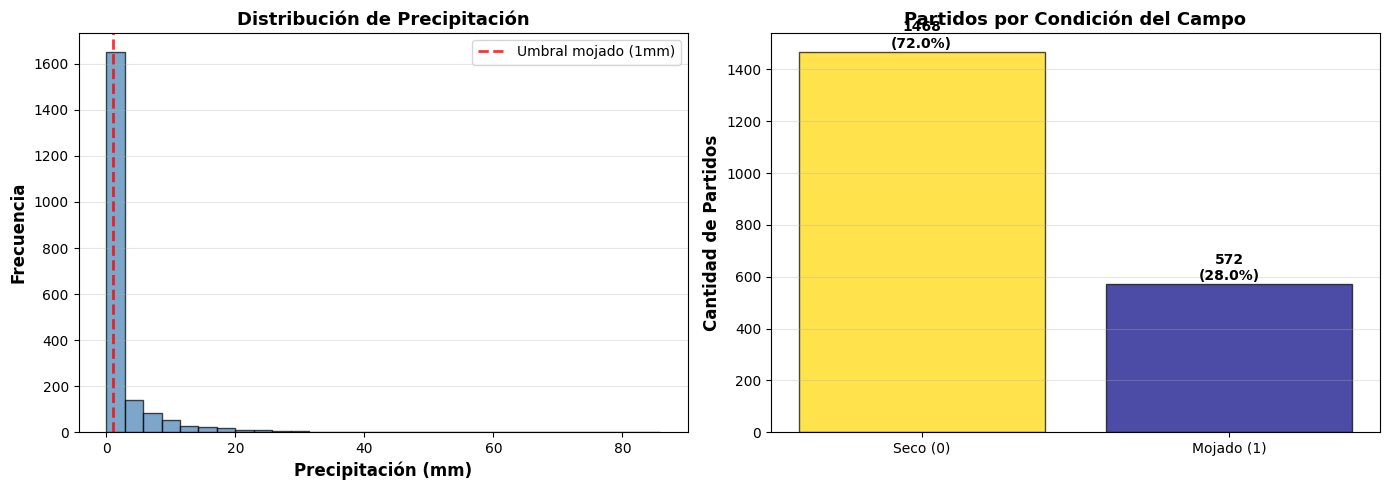


✅ FEATURES DE LLUVIA AGREGADAS CORRECTAMENTE
📊 Shape final del DataFrame: (2040, 55)


In [ ]:
import requests
import pandas as pd
from datetime import datetime
import time

# ===========================
# 1. DICCIONARIO DE COORDENADAS DE ESTADIOS (LA LIGA)
# ===========================

STADIUMS_COORDS = {
    "Real Madrid": {"lat": 40.4531, "lon": -3.6884},
    "Barcelona": {"lat": 41.3809, "lon": 2.1228},
    "Atlético Madrid": {"lat": 40.4362, "lon": -3.5995},
    "Sevilla": {"lat": 37.3838, "lon": -5.9706},
    "Valencia": {"lat": 39.4754, "lon": -0.3583},
    "Athletic Club": {"lat": 43.2641, "lon": -2.9493},
    "Real Sociedad": {"lat": 43.3011, "lon": -1.9732},
    "Villarreal": {"lat": 39.9442, "lon": -0.1039},
    "Betis": {"lat": 37.3564, "lon": -5.9816},
    "Celta Vigo": {"lat": 42.2125, "lon": -8.7394},
    "Espanyol": {"lat": 41.3479, "lon": 2.0753},
    "Getafe": {"lat": 40.3254, "lon": -3.7147},
    "Girona": {"lat": 41.9616, "lon": 2.8267},
    "Alavés": {"lat": 42.8386, "lon": -2.6880},
    "Eibar": {"lat": 43.1844, "lon": -2.4714},
    "Leganés": {"lat": 40.3402, "lon": -3.7677},
    "Levante": {"lat": 39.4909, "lon": -0.3658},
    "Mallorca": {"lat": 39.5905, "lon": 2.6305},
    "Osasuna": {"lat": 42.7967, "lon": -1.6367},
    "Rayo Vallecano": {"lat": 40.3918, "lon": -3.6588},
    "Valladolid": {"lat": 41.6442, "lon": -4.7614},
    "Huesca": {"lat": 42.1400, "lon": -0.4086},
    "Elche": {"lat": 38.2703, "lon": -0.6903},
    "Cádiz": {"lat": 36.5047, "lon": -6.2719},
    "Almería": {"lat": 36.8897, "lon": -2.2860},
    "Las Palmas": {"lat": 28.0993, "lon": -15.4541},
    "Granada": {"lat": 37.1544, "lon": -3.5950}
}

# ===========================
# 2. FUNCIÓN PARA OBTENER DATOS DE LLUVIA
# ===========================

def get_rain_data(lat, lon, date_str):
    """
    Obtiene datos de lluvia usando Open-Meteo API (gratuita)
    
    Args:
        lat: Latitud del estadio
        lon: Longitud del estadio
        date_str: Fecha en formato 'YYYY-MM-DD'
    
    Returns:
        dict con {'precipitation': mm, 'is_wet': 0/1} o None si falla
    """
    try:
        base_url = "https://archive-api.open-meteo.com/v1/archive"
        
        params = {
            "latitude": lat,
            "longitude": lon,
            "start_date": date_str,
            "end_date": date_str,
            "daily": ["precipitation_sum", "rain_sum"],
            "timezone": "auto"
        }
        
        response = requests.get(base_url, params=params, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            
            if "daily" in data:
                daily = data["daily"]
                precipitation = daily["precipitation_sum"][0] or 0.0
                
                # Clasificación: partido mojado si llovió > 1mm
                is_wet = 1 if precipitation > 1.0 else 0
                
                return {
                    "precipitation_mm": round(precipitation, 2),
                    "is_wet_pitch": is_wet
                }
        
        return None
        
    except Exception as e:
        print(f"⚠️ Error API para {date_str}: {str(e)}")
        return None

# ===========================
# 3. FUNCIÓN PARA PARSEAR FECHA
# ===========================

def parse_date(date_value):
    """Convierte diferentes formatos de fecha a 'YYYY-MM-DD'"""
    try:
        # Si es pandas Timestamp
        if isinstance(date_value, pd.Timestamp):
            return date_value.strftime('%Y-%m-%d')
        
        # Si es datetime
        if isinstance(date_value, datetime):
            return date_value.strftime('%Y-%m-%d')
        
        # Si es string
        if isinstance(date_value, str):
            # Intentar diferentes formatos
            for fmt in ['%Y-%m-%d', '%d/%m/%Y', '%m/%d/%Y', '%Y/%m/%d']:
                try:
                    dt = datetime.strptime(date_value, fmt)
                    return dt.strftime('%Y-%m-%d')
                except:
                    continue
            
            # Si ya está en formato correcto
            if len(date_value) == 10 and date_value[4] == '-':
                return date_value
        
        return None
        
    except:
        return None

# ===========================
# 4. FUNCIÓN PRINCIPAL - AGREGAR LLUVIA
# ===========================

def add_rain_features(df_data, lst_1, verbose=True):
    """
    Agrega SOLO 2 columnas de lluvia al DataFrame
    
    Args:
        df_data: DataFrame con las features actuales
        lst_1: Lista con [local, away, round, season, date]
        verbose: Mostrar progreso
    
    Returns:
        DataFrame con 2 nuevas columnas:
        - precipitation_mm: Milímetros de lluvia (float)
        - is_wet_pitch: 1 si llovió >1mm, 0 si no (binario)
    """
    
    # Listas para almacenar datos
    precipitation_list = []
    is_wet_list = []
    
    total_matches = sum(1 for match in lst_1 if match[2] >= 5)
    processed = 0
    failed = 0
    
    if verbose:
        print(f"\n🌧️ OBTENIENDO DATOS DE LLUVIA PARA {total_matches} PARTIDOS...")
        print("=" * 70)
    
    for match in lst_1:
        # Saltar partidos antes de jornada 5
        if match[2] < 5:
            continue
        
        local_team = match[0]
        date_value = match[4]
        
        # Parsear fecha
        date_str = parse_date(date_value)
        
        if date_str is None or local_team not in STADIUMS_COORDS:
            # Valores por defecto si falla
            precipitation_list.append(0.0)
            is_wet_list.append(0)
            failed += 1
            continue
        
        # Obtener coordenadas del estadio
        coords = STADIUMS_COORDS[local_team]
        
        # Obtener datos de lluvia
        rain_data = get_rain_data(coords["lat"], coords["lon"], date_str)
        
        if rain_data:
            precipitation_list.append(rain_data["precipitation_mm"])
            is_wet_list.append(rain_data["is_wet_pitch"])
            processed += 1
            
            if verbose and processed % 100 == 0:
                print(f"✅ Procesados: {processed}/{total_matches} ({processed/total_matches*100:.1f}%)")
        else:
            # Valores por defecto si falla la API
            precipitation_list.append(0.0)
            is_wet_list.append(0)
            failed += 1
        
        # Delay para no sobrecargar la API (0.05s = 20 requests/segundo)
        time.sleep(0.05)
    
    # Agregar columnas al DataFrame
    df_data['precipitation_mm'] = precipitation_list
    df_data['is_wet_pitch'] = is_wet_list

    df_weather = df_data[['precipitation_mm','is_wet_pitch']]
    df_weather.to_csv("weather.csv")
    
    
    if verbose:
        print(f"\n✅ DATOS DE LLUVIA AGREGADOS:")
        print(f"   Exitosos: {processed}/{total_matches} ({processed/total_matches*100:.1f}%)")
        print(f"   Fallidos: {failed}/{total_matches} ({failed/total_matches*100:.1f}%)")
        print(f"   Nuevas columnas: 2 (precipitation_mm, is_wet_pitch)")
        
        # Estadísticas rápidas
        wet_count = sum(is_wet_list)
        print(f"\n📊 RESUMEN:")
        print(f"   Partidos en seco: {total_matches - wet_count} ({(total_matches-wet_count)/total_matches*100:.1f}%)")
        print(f"   Partidos con lluvia (>1mm): {wet_count} ({wet_count/total_matches*100:.1f}%)")
        print(f"   Precipitación promedio: {sum(precipitation_list)/len(precipitation_list):.2f} mm")
        print(f"   Precipitación máxima: {max(precipitation_list):.2f} mm")
    
    return df_data

# ===========================
# 5. APLICAR AL DATASET
# ===========================

# Agregar features de lluvia
df_data = add_rain_features(df_data, lst_1, verbose=True)

# ===========================
# 6. VERIFICAR DATOS
# ===========================

print("\n🔍 PRIMERAS FILAS CON DATOS DE LLUVIA:")
print(df_data[['precipitation_mm', 'is_wet_pitch']].head(10))

print("\n📊 ESTADÍSTICAS DETALLADAS:")
print(df_data[['precipitation_mm', 'is_wet_pitch']].describe())

# ===========================
# 7. VISUALIZACIÓN SIMPLE
# ===========================


print("\n✅ FEATURES DE LLUVIA AGREGADAS CORRECTAMENTE")
print(f"📊 Shape final del DataFrame: {df_data.shape}")

In [22]:
df_data = df_data1.copy()


In [7]:
df_w = pd.read_csv("weather.csv")

In [8]:

df_data['precipitation_mm'] = df_w['precipitation_mm'] 
df_data['is_wet_pitch'] = df_w['is_wet_pitch']

✅ Datos preparados:
   X shape: (1417, 97)
   Y shape: (1417,)

📊 División de datos:
   Train: 1133 muestras
   Test:  284 muestras

🔍 Buscando mejores hiperparámetros con XGBoost...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Mejores parámetros encontrados:
   subsample: 0.9
   reg_lambda: 3.0
   reg_alpha: 1
   n_estimators: 200
   min_child_weight: 1
   max_depth: 3
   learning_rate: 0.05
   gamma: 0.3
   colsample_bytree: 1.0

📈 RESULTADOS XGBOOST
TRAIN SET:
  MSE:  2.6489
  RMSE: 1.6275
  MAE:  1.1691
  R²:   0.7104

TEST SET:
  MSE:  7.4324
  RMSE: 2.7263
  MAE:  2.2152
  R²:   0.2903

⚠️ OVERFITTING CHECK:
  Diferencia R²: 0.4201
  Diferencia MAE: 1.0461

Cross-Validation R² (5-fold):
  Mean: 0.2125 (+/- 0.0722)

🔍 PEORES PREDICCIONES (Top 5):
     Real  Predicho  Error  Error_Abs  Error_%
147    15      8.41   6.59       6.59    43.94
252    16      9.54   6.46       6.46    40.40
123    16      9.54   6.46       6.46    40.37
276     4     10.27  -6.27    

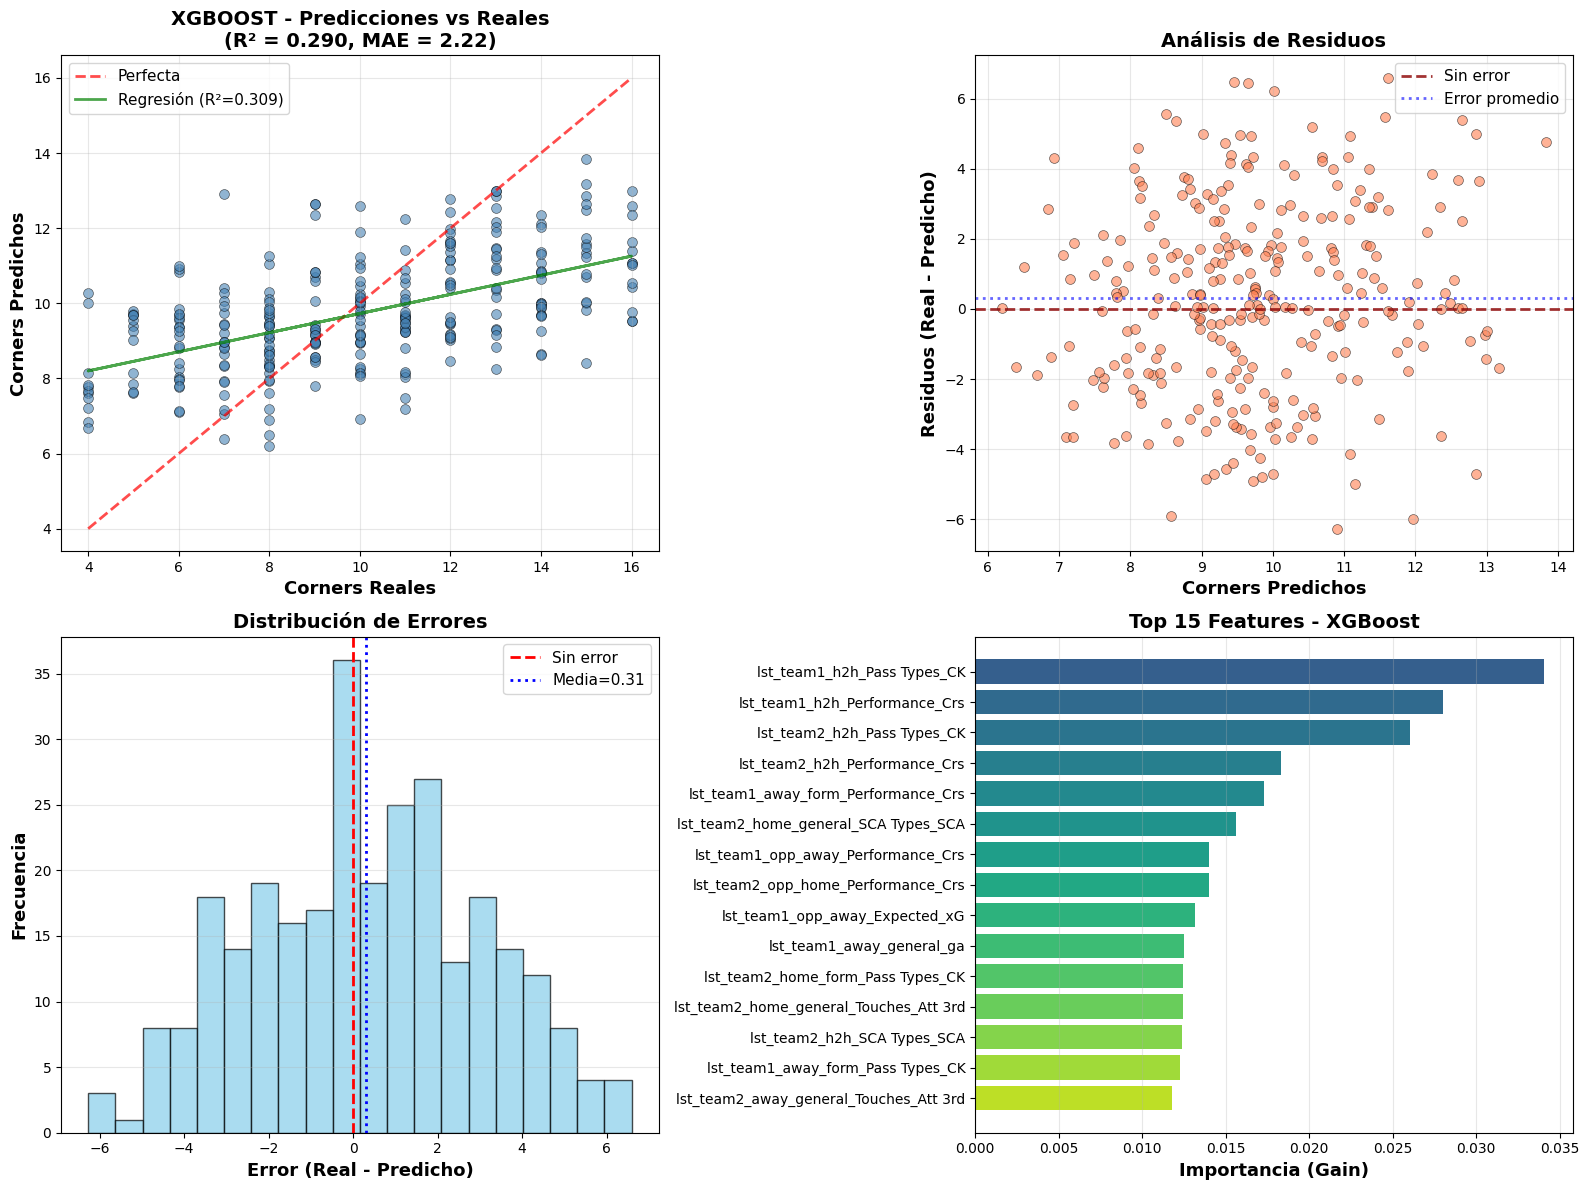


🔍 TOP 20 FEATURES MÁS IMPORTANTES (XGBOOST):
 1. lst_team1_h2h_Pass Types_CK                        0.034090 ██████
 2. lst_team1_h2h_Performance_Crs                      0.028034 █████
 3. lst_team2_h2h_Pass Types_CK                        0.026020 █████
 4. lst_team2_h2h_Performance_Crs                      0.018318 ███
 5. lst_team1_away_form_Performance_Crs                0.017309 ███
 6. lst_team2_home_general_SCA Types_SCA               0.015649 ███
 7. lst_team1_opp_away_Performance_Crs                 0.014026 ██
 8. lst_team2_opp_home_Performance_Crs                 0.013979 ██
 9. lst_team1_opp_away_Expected_xG                     0.013147 ██
10. lst_team1_away_general_ga                          0.012513 ██
11. lst_team2_home_form_Pass Types_CK                  0.012461 ██
12. lst_team2_home_general_Touches_Att 3rd             0.012444 ██
13. lst_team2_h2h_SCA Types_SCA                        0.012361 ██
14. lst_team1_away_form_Pass Types_CK                  0.012247 ██
15.

In [5]:
# ===========================
# XGBOOST REGRESSOR - VERSIÓN COMPLETA
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
import joblib

# ===========================
# 1. PREPARAR LOS DATOS
# ===========================

y_array = np.array(y).flatten()

mask = (y_array >= 4) & (y_array <= 16)

# Aplicar filtro
df_data1 = df_data.copy()

df_data = df_data[mask].copy()
y_array = y_array[mask]

print(f"✅ Datos preparados:")
print(f"   X shape: {df_data.shape}")
print(f"   Y shape: {y_array.shape}")

# Verificar y limpiar datos
assert len(df_data) == len(y_array), f"❌ ERROR: Dimensiones no coinciden"

if df_data.isnull().any().any():
    print(f"⚠️ Hay {df_data.isnull().sum().sum()} valores nulos en X")
    df_data = df_data.fillna(0)

if np.isnan(y_array).any():
    mask = ~np.isnan(y_array)
    df_data = df_data[mask]
    y_array = y_array[mask]

# ===========================
# 2. NORMALIZAR FEATURES (OPCIONAL PARA XGBOOST)
# ===========================

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(df_data),
    columns=df_data.columns
)

# ===========================
# 3. DIVIDIR DATOS
# ===========================

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y_array, 
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"\n📊 División de datos:")
print(f"   Train: {X_train.shape[0]} muestras")
print(f"   Test:  {X_test.shape[0]} muestras")

# ===========================
# 4. OPTIMIZACIÓN DE HIPERPARÁMETROS
# ===========================

print("\n🔍 Buscando mejores hiperparámetros con XGBoost...")

# Modelo base
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",  # Cambiar a 'gpu_hist' si tienes GPU
    n_jobs=-1,
    random_state=42
)

# Grid de hiperparámetros
param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [1],
    "reg_lambda": [3.0],
    "gamma": [0.1, 0.3, 0.5]
}

# Búsqueda aleatoria (más rápido que GridSearch)
rs = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs.fit(X_train, y_train)

print("\n✅ Mejores parámetros encontrados:")
for param, value in rs.best_params_.items():
    print(f"   {param}: {value}")

# ===========================
# 5. RE-ENTRENAR CON EARLY STOPPING
# ===========================

# Split interno para validación
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=43
)

# Crear modelo con mejores parámetros
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    
    # PARÁMETROS CLAVE PARA CORNERS
    n_estimators=300,           # Más árboles para capturar patrones
    max_depth=4,                # Profundidad moderada (evita overfitting)
    learning_rate=0.03,         # Learning rate bajo (más estable)
    
    # REGULARIZACIÓN (importante con 100+ features)
    reg_alpha=0.5,              # L1 (Lasso) - elimina features irrelevantes
    reg_lambda=2.0,             # L2 (Ridge) - controla magnitudes
    gamma=0.3,                  # Min loss reduction
    
    # MUESTREO (reduce overfitting)
    subsample=0.7,              # 70% de muestras por árbol
    colsample_bytree=0.7,       # 70% de features por árbol
    colsample_bylevel=0.7,      # 70% de features por nivel
    
    # OTROS
    min_child_weight=3,         # Min samples en hoja
    random_state=42,
    n_jobs=-1,
    tree_method="hist"          # Más rápido
)

# Entrenar con early stopping (versión compatible)
xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# ===========================
# 6. EVALUAR MODELO
# ===========================

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Métricas
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n📈 RESULTADOS XGBOOST")
print("=" * 50)
print(f"TRAIN SET:")
print(f"  MSE:  {train_mse:.4f}")
print(f"  RMSE: {np.sqrt(train_mse):.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"\nTEST SET:")
print(f"  MSE:  {test_mse:.4f}")
print(f"  RMSE: {np.sqrt(test_mse):.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")

# Diferencia entre Train y Test (indicador de overfitting)
print(f"\n⚠️ OVERFITTING CHECK:")
print(f"  Diferencia R²: {abs(train_r2 - test_r2):.4f}")
print(f"  Diferencia MAE: {abs(train_mae - test_mae):.4f}")

# Cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print(f"\nCross-Validation R² (5-fold):")
print(f"  Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# ===========================
# 7. ANÁLISIS DE PREDICCIONES
# ===========================

comparison = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_test_pred,
    'Error': y_test - y_test_pred,
    'Error_Abs': np.abs(y_test - y_test_pred),
    'Error_%': (np.abs(y_test - y_test_pred) / np.maximum(y_test, 1) * 100)
})
comparison = comparison.sort_values('Error_Abs', ascending=False)

print("\n🔍 PEORES PREDICCIONES (Top 5):")
print(comparison.head(5).to_string())

print("\n✅ MEJORES PREDICCIONES (Top 5):")
print(comparison.tail(5).to_string())

# Estadísticas de error
print(f"\n📊 ESTADÍSTICAS DE ERROR:")
print(f"  Error promedio: {comparison['Error'].mean():.2f}")
print(f"  Error mediano: {comparison['Error'].median():.2f}")
print(f"  Error estándar: {comparison['Error'].std():.2f}")
print(f"  % predicciones con error <2: {(comparison['Error_Abs'] < 2).sum() / len(comparison) * 100:.1f}%")
print(f"  % predicciones con error <3: {(comparison['Error_Abs'] < 3).sum() / len(comparison) * 100:.1f}%")

# ===========================
# 8. VISUALIZACIONES MEJORADAS
# ===========================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 8.1 Predicciones vs Reales (Test)
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_test_pred)

axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, s=50, color='steelblue', edgecolors='k', linewidths=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfecta', alpha=0.7)
axes[0, 0].plot(y_test, slope * y_test + intercept, 'g-', lw=2, 
                label=f'Regresión (R²={r_value**2:.3f})', alpha=0.7)
axes[0, 0].set_xlabel('Corners Reales', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Corners Predichos', fontsize=13, fontweight='bold')
axes[0, 0].set_title(f'XGBOOST - Predicciones vs Reales\n(R² = {test_r2:.3f}, MAE = {test_mae:.2f})', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 8.2 Residuos vs Predicciones
axes[0, 1].scatter(y_test_pred, comparison['Error'], alpha=0.6, s=50, color='coral', edgecolors='k', linewidths=0.5)
axes[0, 1].axhline(y=0, color='darkred', linestyle='--', lw=2, label='Sin error', alpha=0.8)
axes[0, 1].axhline(y=comparison['Error'].mean(), color='blue', linestyle=':', lw=2, 
                   label='Error promedio', alpha=0.6)
axes[0, 1].set_xlabel('Corners Predichos', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Residuos (Real - Predicho)', fontsize=13, fontweight='bold')
axes[0, 1].set_title('Análisis de Residuos', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 8.3 Distribución de errores
axes[1, 0].hist(comparison['Error'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', lw=2, label='Sin error')
axes[1, 0].axvline(x=comparison['Error'].mean(), color='blue', linestyle=':', lw=2, 
                   label=f"Media={comparison['Error'].mean():.2f}")
axes[1, 0].set_xlabel('Error (Real - Predicho)', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Frecuencia', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Distribución de Errores', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 8.4 Feature Importance (Top 15)
feature_importance = pd.DataFrame({
    'feature': df_data.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'], fontsize=10)
axes[1, 1].set_xlabel('Importancia (Gain)', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Top 15 Features - XGBoost', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ===========================
# 9. FEATURE IMPORTANCE DETALLADA
# ===========================

print("\n🔍 TOP 20 FEATURES MÁS IMPORTANTES (XGBOOST):")
print("=" * 75)
top_features = pd.DataFrame({
    'Feature': df_data.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

for idx, (_, row) in enumerate(top_features.iterrows(), 1):
    bar = '█' * int(row['Importance'] * 200)
    print(f"{idx:2d}. {row['Feature']:50s} {row['Importance']:.6f} {bar}")

# ===========================
# 10. GUARDAR MODELO Y SCALER
# ===========================

joblib.dump(xgb_model, 'xgboost_corners_optimized.pkl')
joblib.dump(scaler, 'scaler_corners_xgb.pkl')
print("\n💾 Modelo guardado como 'xgboost_corners_optimized.pkl'")
print("💾 Scaler guardado como 'scaler_corners_xgb.pkl'")

# ===========================
# 11. COMPARACIÓN VISUAL CON RANDOM FOREST (OPCIONAL)
# ===========================

print("\n📊 COMPARACIÓN RÁPIDA:")
print(f"{'Modelo':<20} {'Train R²':<12} {'Test R²':<12} {'Overfitting':<12}")
print("-" * 60)
print(f"{'XGBoost':<20} {train_r2:<12.4f} {test_r2:<12.4f} {abs(train_r2-test_r2):<12.4f}")

# Si ya tienes el modelo Random Forest cargado, puedes comparar:
# print(f"{'Random Forest':<20} {rf_train_r2:<12.4f} {rf_test_r2:<12.4f} {abs(rf_train_r2-rf_test_r2):<12.4f}")


📊 ANÁLISIS DE RENDIMIENTO POR LÍNEAS DE OVER/UNDER

📈 TABLA DE RESULTADOS:
Línea  Over_Accuracy  Over_Precision  Over_Total  Over_Pred  Under_Accuracy  Under_Precision  Under_Total  Under_Pred  Total_Accuracy  Total_Correct
  7.5          96.76           77.99         216        268           13.24            56.25           68          16           76.76            218
  8.5          90.61           73.21         181        224           41.75            71.67          103          60           72.89            207
  9.5          71.97           74.34         157        152           69.29            66.67          127         132           70.77            201
 10.5          50.00           76.83         126         82           87.97            68.81          158         202           71.13            202
 11.5          29.29           80.56          99         36           96.22            71.77          185         248           72.89            207
 12.5          13.70          

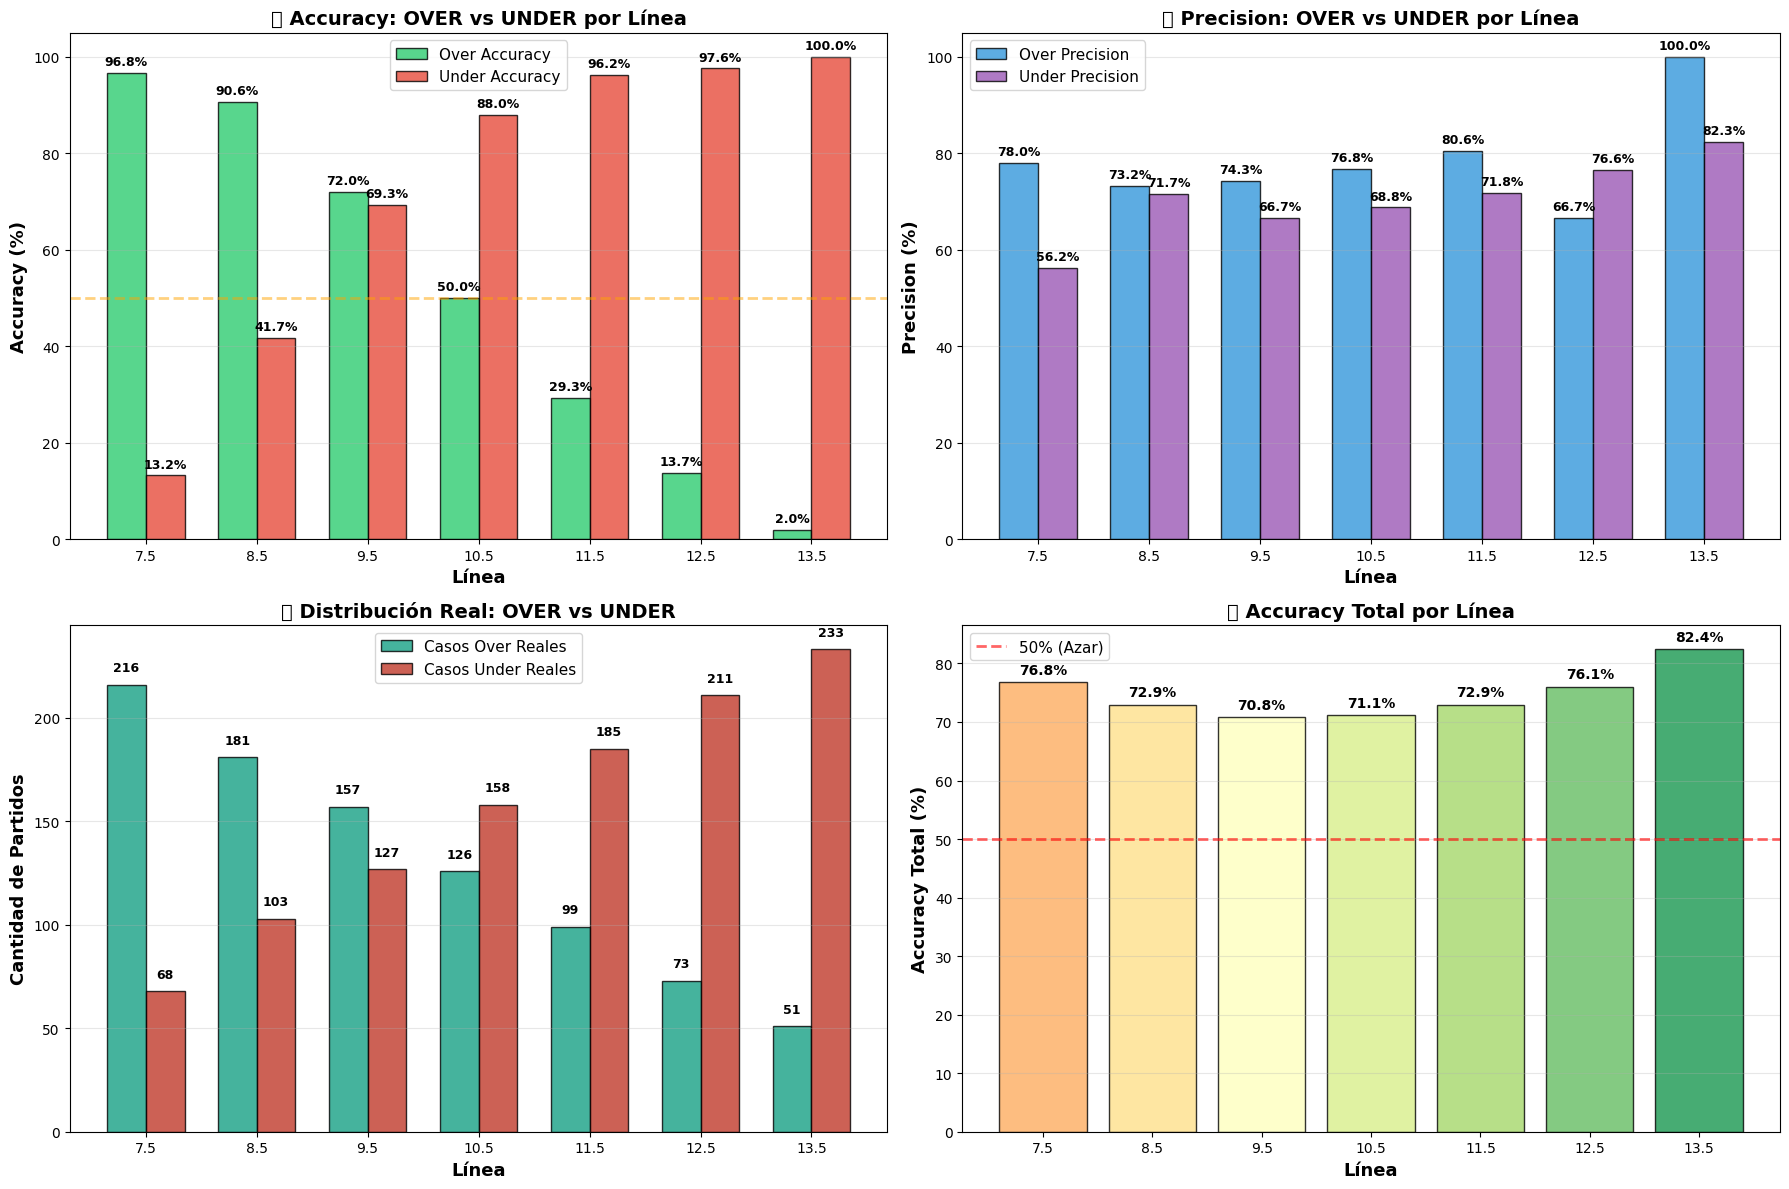

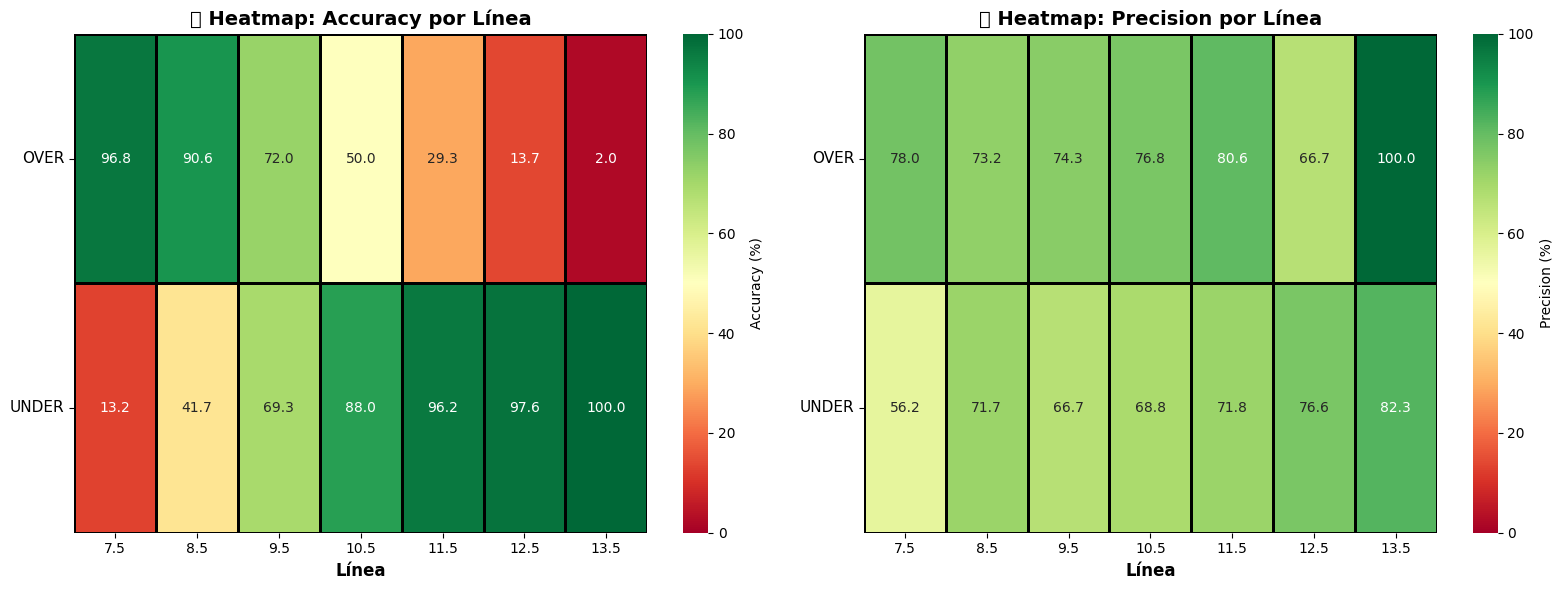


📋 RESUMEN EJECUTIVO

✅ MEJOR LÍNEA PARA OVER:
   Línea: 7.5
   Accuracy: 96.76%
   Precision: 77.99%
   Casos totales: 216

✅ MEJOR LÍNEA PARA UNDER:
   Línea: 13.5
   Accuracy: 100.00%
   Precision: 82.33%
   Casos totales: 233

🏆 MEJOR LÍNEA GENERAL:
   Línea: 13.5
   Accuracy Total: 82.39%
   Aciertos: 234/284

⭐ LÍNEAS CON ACCURACY ≥ 60%:
   • 7.5: 76.76%
   • 8.5: 72.89%
   • 9.5: 70.77%
   • 10.5: 71.13%
   • 11.5: 72.89%
   • 12.5: 76.06%
   • 13.5: 82.39%

⚠️ ADVERTENCIAS:
   • Líneas débiles para OVER (< 50%):
     - 11.5: 29.29%
     - 12.5: 13.70%
     - 13.5: 1.96%
   • Líneas débiles para UNDER (< 50%):
     - 7.5: 13.24%
     - 8.5: 41.75%


💾 Resultados guardados en 'over_under_performance.csv'


In [6]:
# ===========================
# ANÁLISIS DE OVER/UNDER POR LÍNEAS
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_over_under_performance(y_real, y_pred, lines=None):
    """
    Analiza el rendimiento del modelo en diferentes líneas de Over/Under
    
    Args:
        y_real: Valores reales de corners
        y_pred: Valores predichos por el modelo
        lines: Lista de líneas a analizar (default: [7.5, 8.5, 9.5, 10.5, 11.5, 12.5])
    
    Returns:
        DataFrame con métricas por línea
    """
    
    if lines is None:
        lines = [7.5, 8.5, 9.5, 10.5, 11.5, 12.5]
    
    results = []
    
    for line in lines:
        # Clasificación real
        real_over = (y_real > line).astype(int)
        real_under = (y_real <= line).astype(int)
        
        # Clasificación predicha
        pred_over = (y_pred > line).astype(int)
        pred_under = (y_pred <= line).astype(int)
        
        # Métricas OVER
        over_correct = ((real_over == 1) & (pred_over == 1)).sum()
        over_total = (real_over == 1).sum()
        over_accuracy = (over_correct / over_total * 100) if over_total > 0 else 0
        
        # Predicciones OVER que acertaron
        over_pred_total = (pred_over == 1).sum()
        over_precision = (over_correct / over_pred_total * 100) if over_pred_total > 0 else 0
        
        # Métricas UNDER
        under_correct = ((real_under == 1) & (pred_under == 1)).sum()
        under_total = (real_under == 1).sum()
        under_accuracy = (under_correct / under_total * 100) if under_total > 0 else 0
        
        # Predicciones UNDER que acertaron
        under_pred_total = (pred_under == 1).sum()
        under_precision = (under_correct / under_pred_total * 100) if under_pred_total > 0 else 0
        
        # Accuracy general en esta línea
        total_correct = over_correct + under_correct
        total_accuracy = (total_correct / len(y_real) * 100)
        
        results.append({
            'Línea': f"{line}",
            'Over_Accuracy': over_accuracy,
            'Over_Precision': over_precision,
            'Over_Total': over_total,
            'Over_Pred': over_pred_total,
            'Under_Accuracy': under_accuracy,
            'Under_Precision': under_precision,
            'Under_Total': under_total,
            'Under_Pred': under_pred_total,
            'Total_Accuracy': total_accuracy,
            'Total_Correct': total_correct
        })
    
    return pd.DataFrame(results)

# ===========================
# EJECUTAR ANÁLISIS
# ===========================

print("\n" + "=" * 80)
print("📊 ANÁLISIS DE RENDIMIENTO POR LÍNEAS DE OVER/UNDER")
print("=" * 80)

# Líneas a analizar
lines_to_test = [7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5]

# Realizar análisis
df_performance = analyze_over_under_performance(
    y_test, 
    y_test_pred, 
    lines=lines_to_test
)

# Mostrar resultados
print("\n📈 TABLA DE RESULTADOS:")
print("=" * 80)
print(df_performance.to_string(index=False))

# ===========================
# VISUALIZACIÓN 1: GRÁFICO DE BARRAS AGRUPADAS
# ===========================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1.1 Accuracy OVER vs UNDER
x = np.arange(len(df_performance))
width = 0.35

axes[0, 0].bar(x - width/2, df_performance['Over_Accuracy'], width, 
               label='Over Accuracy', color='#2ecc71', alpha=0.8, edgecolor='black')
axes[0, 0].bar(x + width/2, df_performance['Under_Accuracy'], width, 
               label='Under Accuracy', color='#e74c3c', alpha=0.8, edgecolor='black')

axes[0, 0].set_xlabel('Línea', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[0, 0].set_title('🎯 Accuracy: OVER vs UNDER por Línea', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(df_performance['Línea'])
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=50, color='orange', linestyle='--', lw=2, alpha=0.5, label='50% (Azar)')

# Agregar valores en las barras
for i, v in enumerate(df_performance['Over_Accuracy']):
    axes[0, 0].text(i - width/2, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
for i, v in enumerate(df_performance['Under_Accuracy']):
    axes[0, 0].text(i + width/2, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 1.2 Precision OVER vs UNDER
axes[0, 1].bar(x - width/2, df_performance['Over_Precision'], width, 
               label='Over Precision', color='#3498db', alpha=0.8, edgecolor='black')
axes[0, 1].bar(x + width/2, df_performance['Under_Precision'], width, 
               label='Under Precision', color='#9b59b6', alpha=0.8, edgecolor='black')

axes[0, 1].set_xlabel('Línea', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Precision (%)', fontsize=13, fontweight='bold')
axes[0, 1].set_title('🔍 Precision: OVER vs UNDER por Línea', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(df_performance['Línea'])
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(df_performance['Over_Precision']):
    axes[0, 1].text(i - width/2, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
for i, v in enumerate(df_performance['Under_Precision']):
    axes[0, 1].text(i + width/2, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 1.3 Distribución de casos reales
axes[1, 0].bar(x - width/2, df_performance['Over_Total'], width, 
               label='Casos Over Reales', color='#16a085', alpha=0.8, edgecolor='black')
axes[1, 0].bar(x + width/2, df_performance['Under_Total'], width, 
               label='Casos Under Reales', color='#c0392b', alpha=0.8, edgecolor='black')

axes[1, 0].set_xlabel('Línea', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Cantidad de Partidos', fontsize=13, fontweight='bold')
axes[1, 0].set_title('📊 Distribución Real: OVER vs UNDER', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(df_performance['Línea'])
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(df_performance['Over_Total']):
    axes[1, 0].text(i - width/2, v + 5, f'{int(v)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for i, v in enumerate(df_performance['Under_Total']):
    axes[1, 0].text(i + width/2, v + 5, f'{int(v)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 1.4 Accuracy Total por Línea
colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(df_performance)))
bars = axes[1, 1].bar(x, df_performance['Total_Accuracy'], 
                      color=colors_gradient, alpha=0.8, edgecolor='black')

axes[1, 1].set_xlabel('Línea', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Accuracy Total (%)', fontsize=13, fontweight='bold')
axes[1, 1].set_title('🎯 Accuracy Total por Línea', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(df_performance['Línea'])
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].axhline(y=50, color='red', linestyle='--', lw=2, alpha=0.6, label='50% (Azar)')
axes[1, 1].legend(fontsize=11)

for i, v in enumerate(df_performance['Total_Accuracy']):
    axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ===========================
# VISUALIZACIÓN 2: HEATMAP COMPARATIVO
# ===========================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Preparar datos para heatmap
heatmap_data_accuracy = df_performance[['Línea', 'Over_Accuracy', 'Under_Accuracy']].set_index('Línea').T
heatmap_data_precision = df_performance[['Línea', 'Over_Precision', 'Under_Precision']].set_index('Línea').T

# 2.1 Heatmap Accuracy
sns.heatmap(heatmap_data_accuracy, annot=True, fmt='.1f', cmap='RdYlGn', 
            vmin=0, vmax=100, cbar_kws={'label': 'Accuracy (%)'}, 
            ax=axes[0], linewidths=2, linecolor='black')
axes[0].set_title('🔥 Heatmap: Accuracy por Línea', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Línea', fontsize=12, fontweight='bold')
axes[0].set_yticklabels(['OVER', 'UNDER'], rotation=0, fontsize=11)

# 2.2 Heatmap Precision
sns.heatmap(heatmap_data_precision, annot=True, fmt='.1f', cmap='RdYlGn', 
            vmin=0, vmax=100, cbar_kws={'label': 'Precision (%)'}, 
            ax=axes[1], linewidths=2, linecolor='black')
axes[1].set_title('🔥 Heatmap: Precision por Línea', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Línea', fontsize=12, fontweight='bold')
axes[1].set_yticklabels(['OVER', 'UNDER'], rotation=0, fontsize=11)

plt.tight_layout()
plt.show()

# ===========================
# RESUMEN EJECUTIVO
# ===========================

print("\n" + "=" * 80)
print("📋 RESUMEN EJECUTIVO")
print("=" * 80)

# Mejor línea para OVER
best_over_line = df_performance.loc[df_performance['Over_Accuracy'].idxmax()]
print(f"\n✅ MEJOR LÍNEA PARA OVER:")
print(f"   Línea: {best_over_line['Línea']}")
print(f"   Accuracy: {best_over_line['Over_Accuracy']:.2f}%")
print(f"   Precision: {best_over_line['Over_Precision']:.2f}%")
print(f"   Casos totales: {int(best_over_line['Over_Total'])}")

# Mejor línea para UNDER
best_under_line = df_performance.loc[df_performance['Under_Accuracy'].idxmax()]
print(f"\n✅ MEJOR LÍNEA PARA UNDER:")
print(f"   Línea: {best_under_line['Línea']}")
print(f"   Accuracy: {best_under_line['Under_Accuracy']:.2f}%")
print(f"   Precision: {best_under_line['Under_Precision']:.2f}%")
print(f"   Casos totales: {int(best_under_line['Under_Total'])}")

# Mejor línea general
best_total_line = df_performance.loc[df_performance['Total_Accuracy'].idxmax()]
print(f"\n🏆 MEJOR LÍNEA GENERAL:")
print(f"   Línea: {best_total_line['Línea']}")
print(f"   Accuracy Total: {best_total_line['Total_Accuracy']:.2f}%")
print(f"   Aciertos: {int(best_total_line['Total_Correct'])}/{len(y_test)}")

# Líneas por encima del 60% de accuracy
high_accuracy_lines = df_performance[df_performance['Total_Accuracy'] >= 60]
if len(high_accuracy_lines) > 0:
    print(f"\n⭐ LÍNEAS CON ACCURACY ≥ 60%:")
    for _, row in high_accuracy_lines.iterrows():
        print(f"   • {row['Línea']}: {row['Total_Accuracy']:.2f}%")
else:
    print(f"\n⚠️ Ninguna línea alcanzó 60% de accuracy total")

# Advertencias
print(f"\n⚠️ ADVERTENCIAS:")
weak_lines_over = df_performance[df_performance['Over_Accuracy'] < 50]
if len(weak_lines_over) > 0:
    print(f"   • Líneas débiles para OVER (< 50%):")
    for _, row in weak_lines_over.iterrows():
        print(f"     - {row['Línea']}: {row['Over_Accuracy']:.2f}%")

weak_lines_under = df_performance[df_performance['Under_Accuracy'] < 50]
if len(weak_lines_under) > 0:
    print(f"   • Líneas débiles para UNDER (< 50%):")
    for _, row in weak_lines_under.iterrows():
        print(f"     - {row['Línea']}: {row['Under_Accuracy']:.2f}%")

print("\n" + "=" * 80)

# ===========================
# GUARDAR RESULTADOS
# ===========================

df_performance.to_csv('over_under_performance.csv', index=False)
print("\n💾 Resultados guardados en 'over_under_performance.csv'")

In [36]:
import plotly.express as plt

plt.histogram(y)


🔻 TOP 20 FEATURES MENOS IMPORTANTES (XGBOOST):
 1. lst_team1_away_form_Poss                           0.005995 ▓▓
 2. is_wet_pitch                                       0.006040 ▓▓▓
 3. precipitation_mm                                   0.006418 ▓▓▓
 4. lst_team1_home_general_SCA Types_SCA               0.006507 ▓▓▓
 5. lst_team1_h2h_Poss                                 0.006594 ▓▓▓
 6. lst_team2_home_form_Poss                           0.006902 ▓▓▓
 7. lst_team1_away_form_SCA Types_SCA                  0.006925 ▓▓▓
 8. lst_team1_home_form_SCA Types_SCA                  0.006969 ▓▓▓
 9. lst_team1_away_general_ga                          0.007095 ▓▓▓
10. lst_team1_away_general_Poss                        0.007117 ▓▓▓
11. lst_team2_home_form_gf                             0.007199 ▓▓▓
12. fifa_rating_away                                   0.007223 ▓▓▓
13. lst_team1_away_form_Expected_xG                    0.007237 ▓▓▓
14. lst_team2_away_form_Touches_Att 3rd                0.007353 ▓▓▓
1

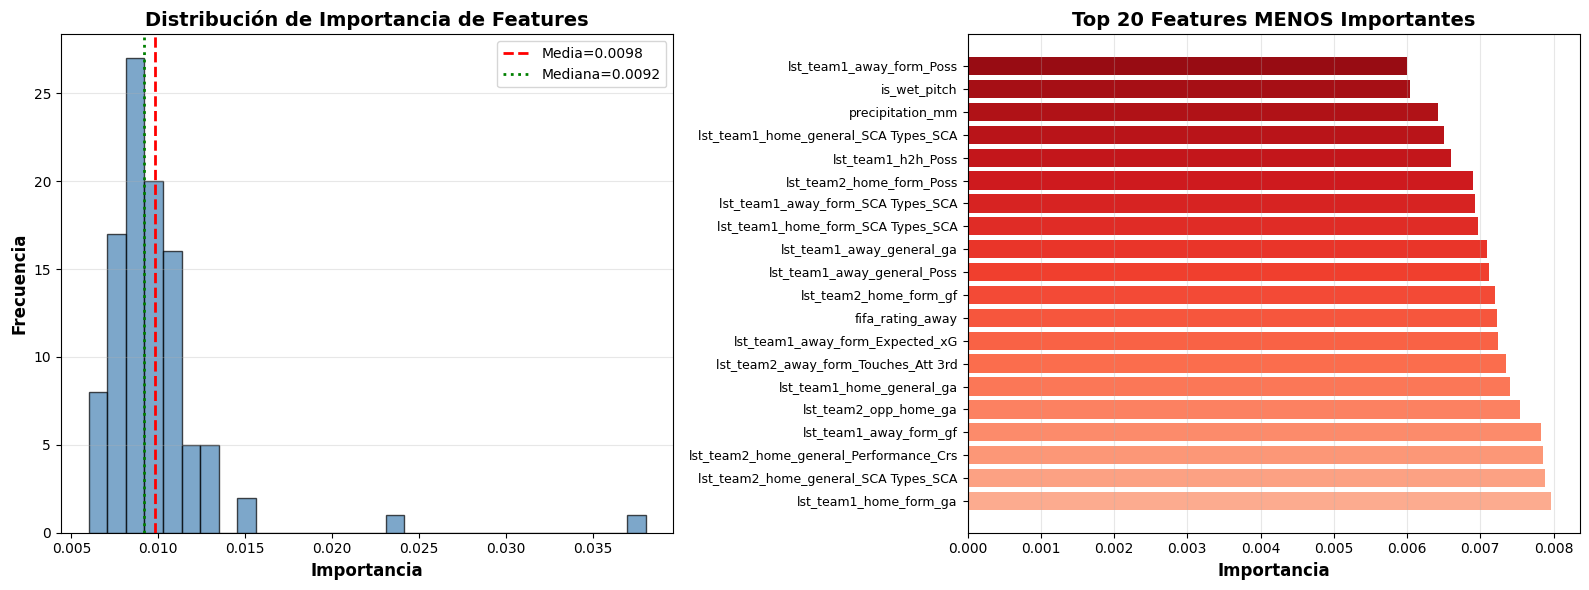


🗑️ FEATURES CANDIDATAS A ELIMINAR (importancia < 0.005):
Total: 0 features

🗑️ FEATURES CANDIDATAS A ELIMINAR (bottom 10%):
Total: 11 features

COMPARACIÓN: MODELO COMPLETO vs MODELO REDUCIDO

🧪 PRUEBA SIN 0 FEATURES:
Shape original: (1784, 102)
Shape reducido: (1784, 102)

📊 RESULTADOS:
  R² (Test): 0.2698
  MAE (Test): 2.0329
  CV R² Mean: 0.2497 (+/- 0.0995)

📊 COMPARACIÓN FINAL:
Modelo                         R² (Test)       MAE (Test)     
------------------------------------------------------------
Original (todas features)      0.2624          2.1252         
Reducido (sin {len(features_to_remove_threshold)} features) 0.2698          2.0329         

✅ RECOMENDACIÓN: Puedes eliminar estas 0 features sin perder rendimiento significativo

💾 Lista de 102 features importantes guardada en 'important_features.txt'


In [10]:
# ===========================
# ANÁLISIS DE FEATURES MENOS IMPORTANTES
# ===========================

import pandas as pd
import numpy as np

# Obtener todas las importancias ordenadas
all_features_importance = pd.DataFrame({
    'Feature': df_data.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)  # Ascendente para ver las menos importantes primero

# ===========================
# 1. FEATURES MENOS IMPORTANTES (Bottom 20)
# ===========================

print("\n🔻 TOP 20 FEATURES MENOS IMPORTANTES (XGBOOST):")
print("=" * 75)

bottom_features = all_features_importance.head(20)

for idx, (_, row) in enumerate(bottom_features.iterrows(), 1):
    bar = '▓' * max(1, int(row['Importance'] * 500))  # Escala aumentada para ver diferencias
    print(f"{idx:2d}. {row['Feature']:50s} {row['Importance']:.6f} {bar}")

# ===========================
# 2. ESTADÍSTICAS DE IMPORTANCIA
# ===========================

print("\n📊 ESTADÍSTICAS DE IMPORTANCIA:")
print("=" * 50)
print(f"Total features: {len(all_features_importance)}")
print(f"Importancia promedio: {all_features_importance['Importance'].mean():.6f}")
print(f"Importancia mediana: {all_features_importance['Importance'].median():.6f}")
print(f"Importancia std: {all_features_importance['Importance'].std():.6f}")
print(f"Importancia máxima: {all_features_importance['Importance'].max():.6f}")
print(f"Importancia mínima: {all_features_importance['Importance'].min():.6f}")

# ===========================
# 3. FEATURES CON IMPORTANCIA CASI NULA
# ===========================

threshold_zero = 0.001  # Umbral para considerar "casi cero"
near_zero_features = all_features_importance[all_features_importance['Importance'] < threshold_zero]

print(f"\n⚠️ FEATURES CON IMPORTANCIA < {threshold_zero}:")
print(f"Total: {len(near_zero_features)} features")
if len(near_zero_features) > 0:
    print("\nLista completa:")
    for idx, (_, row) in enumerate(near_zero_features.iterrows(), 1):
        print(f"  {idx:2d}. {row['Feature']:50s} {row['Importance']:.6f}")

# ===========================
# 4. DISTRIBUCIÓN POR PERCENTILES
# ===========================

print("\n📈 DISTRIBUCIÓN DE IMPORTANCIA POR PERCENTILES:")
print("=" * 50)
for percentile in [10, 25, 50, 75, 90]:
    value = np.percentile(all_features_importance['Importance'], percentile)
    count = (all_features_importance['Importance'] <= value).sum()
    print(f"Percentil {percentile:2d}: {value:.6f} ({count} features)")

# ===========================
# 5. VISUALIZACIÓN - TODAS LAS FEATURES
# ===========================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 5.1 Histograma de importancias
axes[0].hist(all_features_importance['Importance'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=all_features_importance['Importance'].mean(), color='red', 
                linestyle='--', lw=2, label=f"Media={all_features_importance['Importance'].mean():.4f}")
axes[0].axvline(x=all_features_importance['Importance'].median(), color='green', 
                linestyle=':', lw=2, label=f"Mediana={all_features_importance['Importance'].median():.4f}")
axes[0].set_xlabel('Importancia', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Importancia de Features', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# 5.2 Bottom 20 features
bottom_20 = all_features_importance.head(20)
colors_bottom = plt.cm.Reds(np.linspace(0.9, 0.3, len(bottom_20)))
axes[1].barh(range(len(bottom_20)), bottom_20['Importance'], color=colors_bottom)
axes[1].set_yticks(range(len(bottom_20)))
axes[1].set_yticklabels(bottom_20['Feature'], fontsize=9)
axes[1].set_xlabel('Importancia', fontsize=12, fontweight='bold')
axes[1].set_title('Top 20 Features MENOS Importantes', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ===========================
# 6. IDENTIFICAR FEATURES A ELIMINAR
# ===========================

# Opción A: Por umbral de importancia
importance_threshold = 0.005  # Ajusta según tus necesidades
features_to_remove_threshold = all_features_importance[
    all_features_importance['Importance'] < importance_threshold
]['Feature'].tolist()

print(f"\n🗑️ FEATURES CANDIDATAS A ELIMINAR (importancia < {importance_threshold}):")
print(f"Total: {len(features_to_remove_threshold)} features")
if len(features_to_remove_threshold) > 0:
    for idx, feat in enumerate(features_to_remove_threshold[:10], 1):
        print(f"  {idx}. {feat}")
    if len(features_to_remove_threshold) > 10:
        print(f"  ... y {len(features_to_remove_threshold) - 10} más")

# Opción B: Por percentil (bottom X%)
bottom_percentile = 10  # Eliminar el 10% menos importante
percentile_value = np.percentile(all_features_importance['Importance'], bottom_percentile)
features_to_remove_percentile = all_features_importance[
    all_features_importance['Importance'] <= percentile_value
]['Feature'].tolist()

print(f"\n🗑️ FEATURES CANDIDATAS A ELIMINAR (bottom {bottom_percentile}%):")
print(f"Total: {len(features_to_remove_percentile)} features")

# ===========================
# 7. ELIMINAR FEATURES Y RE-ENTRENAR (OPCIONAL)
# ===========================

def test_without_features(df_data, features_to_remove, model_type='xgboost'):
    """
    Prueba el modelo sin ciertas features
    
    Args:
        df_data: DataFrame original
        features_to_remove: Lista de features a eliminar
        model_type: 'xgboost' o 'randomforest'
    """
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score, mean_absolute_error
    
    # Crear nuevo DataFrame sin las features
    df_reduced = df_data.drop(columns=features_to_remove, errors='ignore')
    
    print(f"\n🧪 PRUEBA SIN {len(features_to_remove)} FEATURES:")
    print(f"Shape original: {df_data.shape}")
    print(f"Shape reducido: {df_reduced.shape}")
    
    # Normalizar
    scaler_test = StandardScaler()
    X_scaled_test = pd.DataFrame(
        scaler_test.fit_transform(df_reduced),
        columns=df_reduced.columns
    )
    
    # Split
    X_train_test, X_test_test, y_train_test, y_test_test = train_test_split(
        X_scaled_test, y_array, test_size=0.25, random_state=42
    )
    
    # Entrenar modelo rápido
    if model_type == 'xgboost':
        from xgboost import XGBRegressor
        model_test = XGBRegressor(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            random_state=42,
            n_jobs=-1
        )
    else:
        from sklearn.ensemble import RandomForestRegressor
        model_test = RandomForestRegressor(
            n_estimators=200,
            max_depth=6,
            random_state=42,
            n_jobs=-1
        )
    
    model_test.fit(X_train_test, y_train_test)
    
    # Evaluar
    y_test_pred_test = model_test.predict(X_test_test)
    r2_test = r2_score(y_test_test, y_test_pred_test)
    mae_test = mean_absolute_error(y_test_test, y_test_pred_test)
    
    print(f"\n📊 RESULTADOS:")
    print(f"  R² (Test): {r2_test:.4f}")
    print(f"  MAE (Test): {mae_test:.4f}")
    
    # Cross-validation
    cv_scores_test = cross_val_score(model_test, X_train_test, y_train_test, cv=5, scoring='r2')
    print(f"  CV R² Mean: {cv_scores_test.mean():.4f} (+/- {cv_scores_test.std() * 2:.4f})")
    
    return r2_test, mae_test

# Probar sin las features menos importantes
print("\n" + "=" * 75)
print("COMPARACIÓN: MODELO COMPLETO vs MODELO REDUCIDO")
print("=" * 75)

r2_reduced, mae_reduced = test_without_features(
    df_data, 
    features_to_remove_threshold,
    model_type='xgboost'
)

print(f"\n📊 COMPARACIÓN FINAL:")
print(f"{'Modelo':<30} {'R² (Test)':<15} {'MAE (Test)':<15}")
print("-" * 60)
print(f"{'Original (todas features)':<30} {test_r2:<15.4f} {test_mae:<15.4f}")
print(f"{'Reducido (sin {len(features_to_remove_threshold)} features)':<30} {r2_reduced:<15.4f} {mae_reduced:<15.4f}")

difference_r2 = test_r2 - r2_reduced
difference_mae = test_mae - mae_reduced

if abs(difference_r2) < 0.01 and abs(difference_mae) < 0.1:
    print(f"\n✅ RECOMENDACIÓN: Puedes eliminar estas {len(features_to_remove_threshold)} features sin perder rendimiento significativo")
else:
    print(f"\n⚠️ PRECAUCIÓN: Eliminar estas features reduce el rendimiento:")
    print(f"   Pérdida R²: {difference_r2:.4f}")
    print(f"   Cambio MAE: {difference_mae:.4f}")

# ===========================
# 8. GUARDAR LISTA DE FEATURES A MANTENER
# ===========================

# Features importantes (por encima del umbral)
important_features = all_features_importance[
    all_features_importance['Importance'] >= importance_threshold
]['Feature'].tolist()

# Guardar en archivo
with open('important_features.txt', 'w') as f:
    f.write('\n'.join(important_features))

print(f"\n💾 Lista de {len(important_features)} features importantes guardada en 'important_features.txt'")

In [21]:
import plotly.express as px
import plotly.graph_objects as go

# Calcular la matriz de correlación
corr_matrix = df_filtered.corr()

# Crear el mapa de calor con Plotly
fig = px.imshow(
    corr_matrix,
    labels=dict(x="Variables", y="Variables", color="Correlación"),
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    color_continuous_scale='RdBu_r',  # Escala de colores rojo-azul
    aspect="auto",
    text_auto='.2f'  # Mostrar valores con 2 decimales
)

# Personalizar el layout
fig.update_layout(
    title='Mapa de Correlación - Estadísticas de Equipos',
    width=800,
    height=700
)

fig.show()

In [3]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="weather_feature_engineering")

def get_coords(stadium, city):
    location = geolocator.geocode(f"{stadium}, {city}")
    if location:
        return location.latitude, location.longitude
    return None, None

In [4]:
get_coords("bernabeu","madrid")

(40.4530225, -3.687422)

In [ ]:
import requests
import pandas as pd
from datetime import datetime

def get_weather(lat, lon, date):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": date,
        "end_date": date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "windspeed_10m_max"],
        "timezone": "auto"
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    
    if "daily" in data:
        d = data["daily"]
        return {
            "temp_max": d["temperature_2m_max"][0],
            "temp_min": d["temperature_2m_min"][0],
            "precipitation": d["precipitation_sum"][0],
            "wind_speed": d["windspeed_10m_max"][0]
        }
    return None